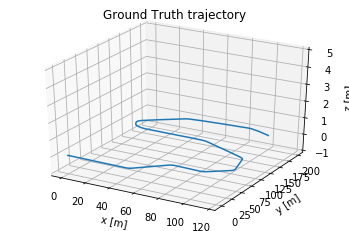

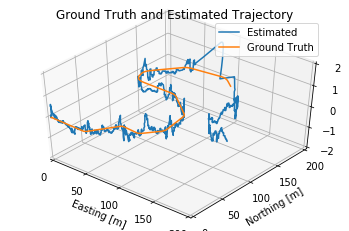

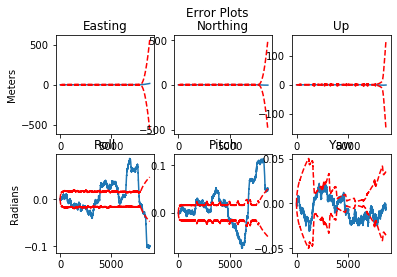

In [36]:
# Starter code for the Coursera SDC Course 2 final project.
#
# Author: Trevor Ablett and Jonathan Kelly
# University of Toronto Institute for Aerospace Studies
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rotations import angle_normalize, rpy_jacobian_axis_angle, skew_symmetric, Quaternion

#### 1. Data ###################################################################################

################################################################################################
# This is where you will load the data from the pickle files. For parts 1 and 2, you will use
# p1_data.pkl. For Part 3, you will use pt3_data.pkl.
################################################################################################
#with open('data/pt1_data.pkl', 'rb') as file:
#    data = pickle.load(file)
    
#--------------- Part 3 --------------------
with open('data/pt3_data.pkl', 'rb') as file:
    data = pickle.load(file)

################################################################################################
# Each element of the data dictionary is stored as an item from the data dictionary, which we
# will store in local variables, described by the following:
#   gt: Data object containing ground truth. with the following fields:
#     a: Acceleration of the vehicle, in the inertial frame
#     v: Velocity of the vehicle, in the inertial frame
#     p: Position of the vehicle, in the inertial frame
#     alpha: Rotational acceleration of the vehicle, in the inertial frame
#     w: Rotational velocity of the vehicle, in the inertial frame
#     r: Rotational position of the vehicle, in Euler (XYZ) angles in the inertial frame
#     _t: Timestamp in ms.
#   imu_f: StampedData object with the imu specific force data (given in vehicle frame).
#     data: The actual data
#     t: Timestamps in ms.
#   imu_w: StampedData object with the imu rotational velocity (given in the vehicle frame).
#     data: The actual data
#     t: Timestamps in ms.
#   gnss: StampedData object with the GNSS data.
#     data: The actual data_
#     t: Timestamps in ms.
#   lidar: StampedData object with the LIDAR data (positions only).
#     data: The actual data
#     t: Timestamps in ms.
################################################################################################
gt = data['gt']
imu_f = data['imu_f']
imu_w = data['imu_w']
gnss = data['gnss']
lidar = data['lidar']

################################################################################################
# Let's plot the ground truth trajectory to see what it looks like. When you're testing your
# code later, feel free to comment this out.
################################################################################################
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth trajectory')
ax.set_zlim(-1, 5)
plt.show()

################################################################################################
# Remember that our LIDAR data is actually just a set of positions estimated from a separate
# scan-matching system, so we can insert it into our solver as another position measurement,
# just as we do for GNSS. However, the LIDAR frame is not the same as the frame shared by the
# IMU and the GNSS. To remedy this, we transform the LIDAR data to the IMU frame using our 
# known extrinsic calibration rotation matrix C_li and translation vector t_i_li.
#
# THIS IS THE CODE YOU WILL MODIFY FOR PART 2 OF THE ASSIGNMENT.
################################################################################################
# Correct calibration rotation matrix, corresponding to Euler RPY angles (0.05, 0.05, 0.1).
C_li = np.array([
   [ 0.99376, -0.09722,  0.05466],
   [ 0.09971,  0.99401, -0.04475],
   [-0.04998,  0.04992,  0.9975 ]
])

# Incorrect calibration rotation matrix, corresponding to Euler RPY angles (0.05, 0.05, 0.05).
#C_li = np.array([
#    [ 0.9975 , -0.04742,  0.05235],
#    [ 0.04992,  0.99763, -0.04742],[-0.04998,  0.04992,  0.9975 ]
#])

t_i_li = np.array([0.5, 0.1, 0.5])

# Transform from the LIDAR frame to the vehicle (IMU) frame.
lidar.data = (C_li @ lidar.data.T).T + t_i_li

#### 2. Constants ##############################################################################

################################################################################################
# Now that our data is set up, we can start getting things ready for our solver. One of the
# most important aspects of a filter is setting the estimated sensor variances correctly.
# We set the values here.
################################################################################################
#--------------Part 1-------------
#var_imu_f = 0.1
#var_imu_w = 0.1
#var_gnss  = 0.01
#var_lidar = 1.00
#--------------Part 2-------------
#var_imu_f = 0.1
#var_imu_w = 0.001
#var_gnss  = 0.01
#var_lidar = 100
#-------------Part 3--------------
var_imu_f = 0.01
var_imu_w = 0.01
var_gnss  = 10.
var_lidar = 1.


################################################################################################
# We can also set up some constants that won't change for any iteration of our solver.
################################################################################################
g = np.array([0, 0, -9.81])  # gravity
l_jac = np.zeros([9, 6])
l_jac[3:, :] = np.eye(6)  # motion model noise jacobian
h_jac = np.zeros([3, 9])
h_jac[:, :3] = np.eye(3)  # measurement model jacobian

#### 3. Initial Values #########################################################################

################################################################################################
# Let's set up some initial values for our ES-EKF solver.
################################################################################################
p_est = np.zeros([imu_f.data.shape[0], 3])  # position estimates
v_est = np.zeros([imu_f.data.shape[0], 3])  # velocity estimates
q_est = np.zeros([imu_f.data.shape[0], 4])  # orientation estimates as quaternions
p_cov = np.zeros([imu_f.data.shape[0], 9, 9])  # covariance matrices at each timestep

# Set initial values.
p_est[0] = gt.p[0]
v_est[0] = gt.v[0]
q_est[0] = Quaternion(euler=gt.r[0]).to_numpy()
p_cov[0] = np.zeros(9)  # covariance of estimate
gnss_i  = 0
lidar_i = 0

# 4. Measurement Update #####################################################################

################################################################################################
# Since we'll need a measurement update for both the GNSS and the LIDAR data, let's make
# a function for it.
################################################################################################
#import sympy as sp

#def gaussian(x, mu, sig):
#    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def measurement_update(sensor_var, p_cov_check, y_k, p_check, v_check, q_check):
    
    I = np.identity(3)
    R = I * sensor_var
    
    # 3.1 Compute Kalman Gain
    K = p_cov_check@ h_jac.T@ np.linalg.inv([h_jac@p_cov_check@h_jac.T + R]) # ==> 9x3 matrix 
    #print("kalman Gain (K) : ", K)
    
    # 3.2 Compute error state
    error_state = (K @ (y_k - p_check).reshape((3,1))).squeeze() # result ==> 9x1 vector
    #print("error_state : ", error_state.shape)
    
    # 3.3 Correct predicted state
    p_hat = p_check + error_state[:3]
    v_hat = v_check + error_state[3:6]
    error_state_q = error_state[6:]
    
    q_hat = Quaternion(euler=error_state_q).quat_mult_right(q_check)
    
    # 3.4 Compute corrected covariance
    p_cov_hat = (np.identity(9) - K@h_jac)@ p_cov_check # result ==> 9x9 matrix
    

    return p_hat, v_hat, q_hat, p_cov_hat

#### 5. Main Filter Loop #######################################################################

################################################################################################
# Now that everything is set up, we can start taking in the sensor data and creating estimates
# for our state in a loop.
################################################################################################
for k in range(1, imu_f.data.shape[0]):  # start at 1 b/c we have initial prediction from gt
    delta_t = imu_f.t[k] - imu_f.t[k - 1]

    # 1. Update state with IMU inputs
    C_ns = Quaternion(*q_est[k-1]).to_mat()
    p_est[k] = p_est[k-1] + delta_t*v_est[k-1] + ((delta_t**2)/2) * (C_ns@imu_f.data[k-1]+ g)
    v_est[k] = v_est[k-1] + delta_t*(C_ns@imu_f.data[k-1]+ g)
    
    theta = (imu_w.data[k-1] * delta_t)
    q_est[k] = Quaternion(axis_angle = theta).quat_mult_right(q_est[k-1])

    # 1.1 Linearize the motion model and compute Jacobians
    F_jac = np.identity(9)
    F_jac[:3, 3:6] = np.identity(3)*delta_t
    F_jac[3:6, 6:] = -(C_ns.dot(skew_symmetric(imu_f.data[k-1].reshape((3,1)))))
    #different result when using the below code instead of the upper line but still gets 10 out of 10 in submission
    #You can get better results when setting variances of inputs
    #F_jac[3:6, 6:] = -skew_symmetric(C_ns.dot(imu_f.data[k-1])) * delta_t
    
    # 2. Propagate uncertainty
    Q = np.identity(6)
    Q[:, :3] *= delta_t**2 * var_imu_f
    Q[:, -3:] *= delta_t**2 * var_imu_w
    
    p_cov[k] =  F_jac@p_cov[k-1]@F_jac.T + l_jac@Q@l_jac.T
    
    # 3. Check availability of GNSS and LIDAR measurements

    #print(p_cov_check.shape)
    #print(p_check.shape)
    #print(v_check.shape)
    #print(q_check.shape)
    #print('--------------------- k= ', k , ' --------------------' )
    #print("state_check : ",p_check)
    #print(v_check)
    #print(q_check)
    
    if lidar_i < lidar.t.shape[0] and lidar.t[lidar_i] == imu_f.t[k-1]:
        #print("lidar data shape: ",lidar.data[lidar_i].shape)
        p_est[k], v_est[k], q_est[k], p_cov[k] = measurement_update(var_lidar, p_cov[k], lidar.data[lidar_i].T, p_est[k], v_est[k], q_est[k])
        lidar_i += 1
    if gnss_i < gnss.t.shape[0] and gnss.t[gnss_i] == imu_f.t[k-1]:
        #print("gnss data shape: ",gnss.data[gnss_i].shape)
        p_est[k], v_est[k], q_est[k], p_cov[k] = measurement_update(var_gnss, p_cov[k], gnss.data[gnss_i].T, p_est[k], v_est[k], q_est[k])
        gnss_i += 1
        
    #print("state_hat : ",p_est[k])
    #print(v_est[k])
    #print(q_est[k])

    
#### 6. Results and Analysis ###################################################################

################################################################################################
# Now that we have state estimates for all of our sensor data, let's plot the results. This plot
# will show the ground truth and the estimated trajectories on the same plot. Notice that the
# estimated trajectory continues past the ground truth. This is because we will be evaluating
# your estimated poses from the part of the trajectory where you don't have ground truth!
################################################################################################
est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection='3d')
ax.plot(p_est[:,0], p_est[:,1], p_est[:,2], label='Estimated')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2], label='Ground Truth')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_zlabel('Up [m]')
ax.set_title('Ground Truth and Estimated Trajectory')
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_zlim(-2, 2)
ax.set_xticks([0, 50, 100, 150, 200])
ax.set_yticks([0, 50, 100, 150, 200])
ax.set_zticks([-2, -1, 0, 1, 2])
ax.legend(loc=(0.62,0.77))
ax.view_init(elev=45, azim=-50)
plt.show()

################################################################################################
# We can also plot the error for each of the 6 DOF, with estimates for our uncertainty
# included. The error estimates are in blue, and the uncertainty bounds are red and dashed.
# The uncertainty bounds are +/- 3 standard deviations based on our uncertainty (covariance).
################################################################################################
error_fig, ax = plt.subplots(2, 3)
error_fig.suptitle('Error Plots')
num_gt = gt.p.shape[0]
p_est_euler = []
p_cov_euler_std = []

# Convert estimated quaternions to euler angles
for i in range(len(q_est)):
    qc = Quaternion(*q_est[i, :])
    p_est_euler.append(qc.to_euler())

    # First-order approximation of RPY covariance
    J = rpy_jacobian_axis_angle(qc.to_axis_angle())
    p_cov_euler_std.append(np.sqrt(np.diagonal(J @ p_cov[i, 6:, 6:] @ J.T)))

p_est_euler = np.array(p_est_euler)
p_cov_euler_std = np.array(p_cov_euler_std)

# Get uncertainty estimates from P matrix
p_cov_std = np.sqrt(np.diagonal(p_cov[:, :6, :6], axis1=1, axis2=2))

titles = ['Easting', 'Northing', 'Up', 'Roll', 'Pitch', 'Yaw']
for i in range(3):
    ax[0, i].plot(range(num_gt), gt.p[:, i] - p_est[:num_gt, i])
    ax[0, i].plot(range(num_gt),  3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].plot(range(num_gt), -3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].set_title(titles[i])
ax[0,0].set_ylabel('Meters')

for i in range(3):
    ax[1, i].plot(range(num_gt), \
        angle_normalize(gt.r[:, i] - p_est_euler[:num_gt, i]))
    ax[1, i].plot(range(num_gt),  3 * p_cov_euler_std[:num_gt, i], 'r--')
    ax[1, i].plot(range(num_gt), -3 * p_cov_euler_std[:num_gt, i], 'r--')
    ax[1, i].set_title(titles[i+3])
ax[1,0].set_ylabel('Radians')
plt.show()

#### 7. Submission #############################################################################

################################################################################################
# Now we can prepare your results for submission to the Coursera platform. Uncomment the
# corresponding lines to prepare a file that will save your position estimates in a format
# that corresponds to what we're expecting on Coursera.
################################################################################################

# Pt. 1 submission
#p1_indices = [9000, 9400, 9800, 10200, 10600]
#p1_str = ''
#for val in p1_indices:
#    for i in range(3):
#        p1_str += '%.3f ' % (p_est[val, i])
#with open('pt1_submission.txt', 'w') as file:
#    file.write(p1_str)

# Pt. 2 submission
#p2_indices = [9000, 9400, 9800, 10200, 10600]
#p2_str = ''
#for val in p2_indices:
#    for i in range(3):
#        p2_str += '%.3f ' % (p_est[val, i])
#with open('pt2_submission.txt', 'w') as file:
#    file.write(p2_str)

#Pt. 3 submission
p3_indices = [6800, 7600, 8400, 9200, 10000]
p3_str = ''
for val in p3_indices:
    for i in range(3):
        p3_str += '%.3f ' % (p_est[val, i])
with open('pt3_submission.txt', 'w') as file:
    file.write(p3_str)